In [4]:
import netgen.gui
from netgen.csg import *
from ngsolve import *
from ngsolve.solvers import CG
from ngsolve.la import EigenValues_Preconditioner
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def MakeGeometry():
    geometry = CSGeometry()
    box = OrthoBrick(Pnt(0,0,0),Pnt(1,1,1)).bc("outer")
    geometry.Add (box)
    return geometry

ngmesh = MakeGeometry().GenerateMesh(maxh=0.5)
mesh = Mesh(ngmesh)

# Poisson equation

\begin{equation}
\int{\nabla u \ \nabla v dx} = \int{f \ v dx} 
\end{equation}

$f=1$, hom. Dirichlet BC on unit cube $\Omega = (0,1)^3$, maxh = 0.5

In [7]:
ngmesh = MakeGeometry().GenerateMesh(maxh=0.5)
mesh = Mesh(ngmesh)
Draw(mesh)

fes = H1(mesh, order = 3, dirichlet =".*")

u,v = fes.TnT()

a = BilinearForm(fes)#, condense = True)
a += grad(u) * grad(v) * dx

f = LinearForm(fes)
f += 1 * v * dx

c = Preconditioner(a, "multigrid")

gfu = GridFunction(fes)

ndofs = []
nums= []
errs = []
kond = []
L = 6
levels = [l for l in range(L)]
for l in levels:
    if l > 0:
        mesh.Refine()
    fes.Update()
    gfu.Update()
    print(f"(Level: {l}, ndof: {fes.ndof})")
        
    data = []
    with TaskManager():
        f.Assemble()
        a.Assemble()
        #c.Update()
        callback = lambda k,r: data.append((k,r))

        CG(mat=a.mat, pre=c.mat, rhs=f.vec, sol=gfu.vec, printrates=False, maxsteps=10000, tol=1e-8, callback = callback)
        lam = EigenValues_Preconditioner(mat=a.mat, pre=c)
        kond.append(max(lam)/min(lam))
    nums.append(data[-1][0])
    errs.append(data[-1][1])
    ndofs.append(fes.ndof)

ndofs = np.array(ndofs)
hs = np.sqrt(ndofs)
nums = np.array(nums)
errs = np.array(errs)
kond = np.array(kond)
Draw(gfu)
print("Done")

(Level: 0, ndof: 273)
(Level: 1, ndof: 1733)
(Level: 2, ndof: 12321)
(Level: 3, ndof: 92897)
(Level: 4, ndof: 721473)
(Level: 5, ndof: 5686913)
Done


# RAM usage

* level 5: 8GB

* (Level: 6, ndof: 45159681)
    * level 6: 20GB --> 6.6GB in swap
    * level 6: 32GB --> 6.6GB in swap

In [22]:
ndofs = np.array(ndofs)
hs = np.cbrt(1/ndofs)
nums = np.array(nums)
errs = np.array(errs)
kond = np.array(kond)

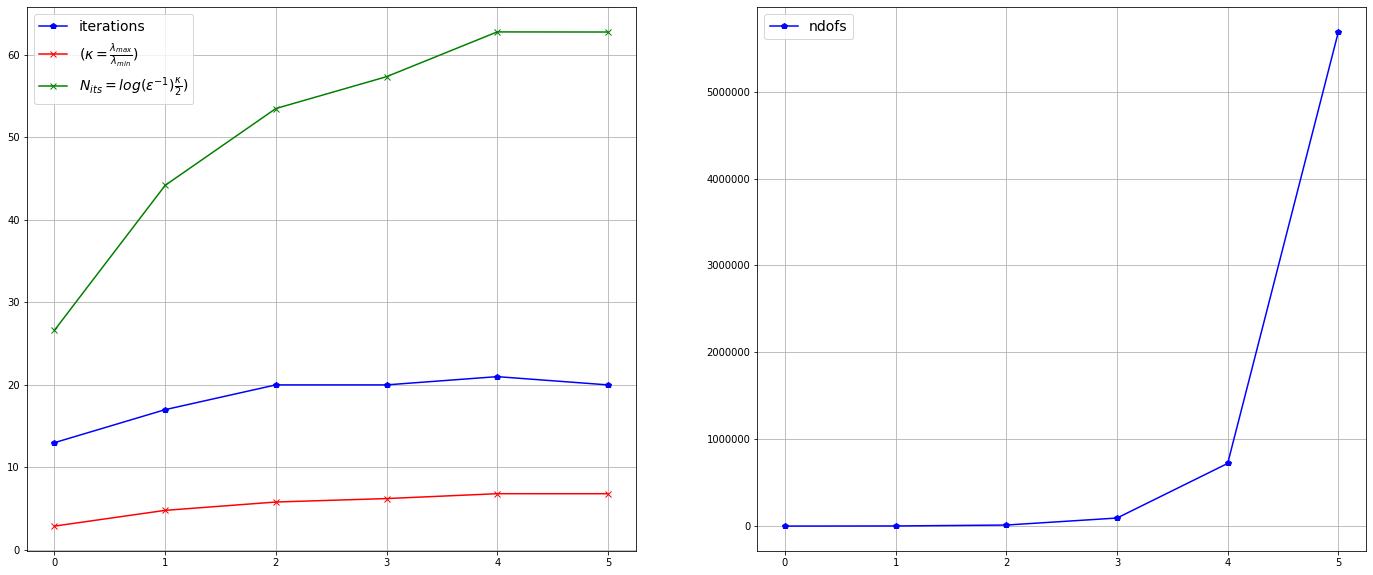

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24,10))
ax1.plot(levels, nums, "b-p", label="iterations")
#ax1.plot(levels, errs*1e10+10, label="last error [1e-10]")
ax1.plot(levels, kond, "r-x",label=r"$(\kappa = \frac{\lambda_{max}}{\lambda_{min}})$")
ax1.plot(levels, kond*np.log(1e8) * 0.5, "g-x",label=r"$N_{its} = log(\epsilon^{-1}) \frac{\kappa}{2})$")
ax2.plot(levels, ndofs, "b-p", label="ndofs")
#ax2.plot(levels, 1/hs*100, label="~1/h*10000")
ax1.grid()
ax1.legend(fontsize=14)
ax2.grid()
ax2.legend(fontsize=14)

Lecture:

\begin{equation}
N_{its} = log(\epsilon)^{-1} \cdot \frac{\kappa}{2}
\end{equation}

and for multigrid

\begin{equation}
u^T C u \leq u^T A u \leq u^T C u \ \rightarrow \kappa = \mathcal{O}(1)
\end{equation}
\begin{equation}

\end{equation}

vs local Jacobi:

\begin{equation}
h^2 \ u^T C u \leq u^T A u \leq u^T C u \ \rightarrow \kappa = \mathcal{O}(1/h)
\end{equation}